<a href="https://colab.research.google.com/github/trinade96/Fortiate_Project/blob/master/TensorBoard_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will be giving a demo about how to use TensorBoard to visualize and then how to continue training after a model has already been trained with some data. This is usually called 'Transfer Learning' since we are somehow transferring previous learning to new tasks.

##### **Packages Used**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, mean_absolute_error
from scipy.stats import chi2_contingency as chi_test
from sklearn.datasets import load_boston
from pandas.api.types import is_float_dtype
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import imblearn
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD,Adam
from keras.utils import np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inputV3

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
print(tf.__version__)

2.2.0


##### **Reading the data**

In [4]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [5]:
data = pd.read_excel('/gdrive/My Drive/Random-Forest-Rules-Final-Rearranged-mindmap.xlsx')
data.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05


In [6]:
data.shape

(105271, 44)

##### We will be treating the data a little differently here, not removing the NaNs but keeping them as a different category so it can be passed to the classifier so we don't loose too data

In [7]:
for col in data.keys():
  data[col] = data[col].fillna(str(col+'NA'))
  print(data[col].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [8]:
data.dropna(axis=0)
data.shape

(105271, 44)

##### Now we will move onto to removing the index like columns and then encoding the dataset to be passed on to the classifier.

##### **Function to remove columns which are a list on distinct values for eg. the index**

In [9]:
def remove_index_like(df):
  df_new = df.copy()
  indices = []
  for i in df_new.columns:
    if len(df[i]) == len(set(df[i])):
      indices.append(i)
  df_new = df_new.drop(indices,1)
  return df_new

In [11]:
data_dt = remove_index_like(data)

In [12]:
data_dt.shape

(105271, 44)

In [13]:
data_dt.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05


##### So there are no index like columns here, so we can simply convert all of them via LabelEncoder to numeric encodings to be passed on to the decision tree, however we will first find out the float type columns and have them be as it is.


##### **Function to remove constant values**


In [14]:
def remove_constants(df):
  df_new = df.copy()
  indices = []
  for col in df_new.columns:
    if len(set(df_new[col])) == 1:
      indices.append(col)
  df_new = df_new.drop(indices,1)
  return df_new

In [15]:
data_dt = remove_constants(data_dt)
data_dt.shape

(105271, 44)

##### Therefore there are no constant columns in the dataset

In [16]:
data_dt.columns

Index(['TRANSACTION_CURRENCY', 'PD4', 'PD11', 'PROC_CODE_12', 'PD8', 'MCC',
       'POS_ENTRY_MODE', 'SERVICE_CODE', 'BILLING_AMOUNT',
       'TRANSACTION_LOCAL_DATE', 'TRANSMISSION_DATE_TIME',
       'RESPONSE_DATE_TIME', 'PAN', 'VALID_FROM', 'EXPIRY_DATE',
       'PROC_CODE_34', 'PROC_CODE_56', 'PD1', 'PD2', 'PD3', 'PD5', 'PD6',
       'PD7', 'PD9', 'PD10', 'PD12', 'TRANSACTION_AMOUNT', 'BILLING_CURRENCY',
       'CONVERSION_RATE_DATE', 'SETTLEMENT_AMOUNT', 'SETTLEMENT_CURRENCY',
       'SETTLEMENT_DATE', 'ACQUIRING_COUNTRY_CODE', 'CARD_ACCEPTOR_TERM_ID',
       'CARD_ACCEPTOR_ID', 'CARD_ACC_NAME_ADDRESS', 'AUTHORIZATION_CODE',
       'DECISION', 'TARGET', 'C_100', 'C_40', 'C_20', 'ECOM_INFO',
       'E_COM_INDICATOR'],
      dtype='object')

In [17]:
set(data_dt.E_COM_INDICATOR.astype('category').cat.codes)

{0, 1, 2, 3, 4, 5, 6}

In [18]:
data_dt2 = data_dt.copy()
data_dt2

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105266,CURR356,ATCX,TOCX,TC26,TVIX,MCC6012,NNN,UNK,10.00,22-MAR-18 20.33.27,22-MAR-18 20.33.27,22-MAR-18 15.03.28,A5756981000264010,01-DEC-49 00.00.00,01-DEC-50 00.00.00,FR00,TO00,CRCX,CVCX,CCCX,PPIX,CPIX,TCRX,TCVX,TWCX,PEIX,10.00,CURR356,000,10.00,CURR356,SETTLEMENT_DATENA,CON356,RVMTTERM,100008,mVisa merchant mVisa paymentIN,062910,RESULT000,0,MOB,ITB,T0011,ECOM_INFONA,ECINA
105267,CURR356,ATC0,TOC0,TC00,TVI0,MCC5399,NNN,UNK,18000.00,22-MAR-18 20.37.09,22-MAR-18 20.37.09,22-MAR-18 20.37.09,A5357314011150000,27-JUN-17 19.40.21,01-JUN-22 00.00.00,FR00,TO98,CRC0,CVC0,CCC0,PPI0,CPI0,TCR1,TCV0,TWC0,PEI0,18000.00,CURR356,000,18000.00,CURR356,22-MAR-18 00.00.00,CON356,RVMTTERM,100008,FARHAT JHAHAN DURRANI INDORE IN,374229,RESULT000,0,MOB,ITB,T0011,ECOM_INFONA,ECINA
105268,CURR356,ATCX,TOCX,TC26,TVIX,MCC6012,NNN,UNK,18000.00,22-MAR-18 20.37.09,22-MAR-18 20.37.09,22-MAR-18 15.07.10,A5756981000264010,01-DEC-49 00.00.00,01-DEC-50 00.00.00,FR00,TO00,CRCX,CVCX,CCCX,PPIX,CPIX,TCRX,TCVX,TWCX,PEIX,18000.00,CURR356,000,18000.00,CURR356,SETTLEMENT_DATENA,CON356,RVMTTERM,100008,mVisa merchant mVisa paymentIN,062926,RESULT000,0,MOB,ITB,T0011,ECOM_INFONA,ECINA
105269,CURR356,ATC0,TOC0,TC00,TVI0,MCC4812,NNN,UNK,18100.00,22-MAR-18 20.39.09,22-MAR-18 20.39.09,22-MAR-18 20.39.09,A5357314011150000,27-JUN-17 19.40.21,01-JUN-22 00.00.00,FR00,TO98,CRC0,CVC0,CCC0,PPI0,CPI0,TCR1,TCV0,TWC0,PEI0,

In [19]:
# So what we will be doing here is that other than the float columns we will be converting all the other columns necessarily to strings
float_cols = []
for col in data_dt2.columns:
  if data_dt2[col].dtype == 'float64':
    float_cols.append(col)

print(float_cols)
data_dt2 = data_dt2.drop(float_cols,axis=1)
data_dt2.head()
#data_dt_custom = data_dt[[x for x in data_dt.columns if x not in ['CONVERSION_RATE_DATE','CARD_ACCEPTOR_ID','AUTHORIZATION_CODE','TARGET']]]
#data_dt_custom.head()

['BILLING_AMOUNT', 'TRANSACTION_AMOUNT', 'SETTLEMENT_AMOUNT']


,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,CURR356,000,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,CURR356,000,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,CURR356,000,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,CURR356,000,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,CURR356,000,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05


##### **Label Encoding of the categorical columns and the keeping the float columns as is**

In [20]:
data_dt_custom = pd.DataFrame()
for col in data_dt2.columns:
  le = LabelEncoder()
  le.fit(data_dt2[col])
  data_dt_custom[col] = le.transform(data_dt2[col])

for col in float_cols:
  data_dt_custom[col] = data_dt[col]

data_dt_custom.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR,BILLING_AMOUNT,TRANSACTION_AMOUNT,SETTLEMENT_AMOUNT
0,14,5,1,0,0,258,14,6,9,0,0,934,28389,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,70860,0,0,0,0,594,21702,3,147.84,147.84,145.22
1,14,5,1,0,0,100,14,6,10,1,1,875,7515,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27698,28286,16588,0,0,0,0,602,21702,3,399.00,399.00,391.94
2,14,5,1,0,0,258,14,6,11,2,2,492,2951,4,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,59898,0,0,0,0,419,21702,3,247.20,247.20,242.82
3,14,5,1,0,0,258,14,6,12,3,3,529,26953,4,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,59907,0,0,0,0,601,21702,3,359.00,359.00,352.65
4,14,5,1,0,0,217,14,6,15,6,5,961,43447,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27548,28293,27344,0,0,0,0,594,21702,3,188.00,188.00,183.81


In [21]:
label_column = 'E_COM_INDICATOR'
input_columns = [x for x in data_dt_custom.columns if x != 'E_COM_INDICATOR']
input_columns

['TRANSACTION_CURRENCY',
 'PD4',
 'PD11',
 'PROC_CODE_12',
 'PD8',
 'MCC',
 'POS_ENTRY_MODE',
 'SERVICE_CODE',
 'TRANSACTION_LOCAL_DATE',
 'TRANSMISSION_DATE_TIME',
 'RESPONSE_DATE_TIME',
 'PAN',
 'VALID_FROM',
 'EXPIRY_DATE',
 'PROC_CODE_34',
 'PROC_CODE_56',
 'PD1',
 'PD2',
 'PD3',
 'PD5',
 'PD6',
 'PD7',
 'PD9',
 'PD10',
 'PD12',
 'BILLING_CURRENCY',
 'CONVERSION_RATE_DATE',
 'SETTLEMENT_CURRENCY',
 'SETTLEMENT_DATE',
 'ACQUIRING_COUNTRY_CODE',
 'CARD_ACCEPTOR_TERM_ID',
 'CARD_ACCEPTOR_ID',
 'CARD_ACC_NAME_ADDRESS',
 'AUTHORIZATION_CODE',
 'DECISION',
 'TARGET',
 'C_100',
 'C_40',
 'C_20',
 'ECOM_INFO',
 'BILLING_AMOUNT',
 'TRANSACTION_AMOUNT',
 'SETTLEMENT_AMOUNT']

##### **We will try to do something similar using TensorBoard**
For reference look at the following link: <br>
https://www.tensorflow.org/tensorboard/get_started


In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


In [23]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [24]:
import datetime

# Dividing the data into train_test_split
X = np.asarray(data_dt_custom[input_columns])
y = np.asarray(data_dt_custom[label_column])
#y = np.array(data_dt_final.loc[:,'TARGET'])
print(X.shape)
print(y.shape)

(105271, 43)
(105271,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(94743, 43)
(10528, 43)
(94743,)
(10528,)


In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,mode="auto")
#Regularizer = l2(0.001)

In [27]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(43,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')  # This number after Dense changes according to the number of categories in the target variable we are trying to predict
  ])

In [28]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


##### **Fitting the model**

In [29]:
log_dir = "/tmp/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Would be preferable to try with around 40 epochs in retrospect, since with 20 which was tried it doesn't quite converge yet
history = model.fit(x=X_train, 
          y=y_train, 
          epochs=40, 
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback, callback])


Epoch 1/40
2961/2961 [==============================] - 8s 3ms/step - loss: 215.5624 - accuracy: 0.7558 - val_loss: 5.8082 - val_accuracy: 0.7921
Epoch 2/40
2961/2961 [==============================] - 8s 3ms/step - loss: 27.1209 - accuracy: 0.7552 - val_loss: 2.3725 - val_accuracy: 0.7875
Epoch 3/40
2961/2961 [==============================] - 7s 3ms/step - loss: 14.5260 - accuracy: 0.7737 - val_loss: 1.1018 - val_accuracy: 0.8004
Epoch 4/40
2961/2961 [==============================] - 8s 3ms/step - loss: 8.1035 - accuracy: 0.7610 - val_loss: 0.7926 - val_accuracy: 0.7960
Epoch 5/40
2961/2961 [==============================] - 8s 3ms/step - loss: 5.0416 - accuracy: 0.7589 - val_loss: 16.7191 - val_accuracy: 0.8042
Epoch 6/40
2961/2961 [==============================] - 8s 3ms/step - loss: 9.9524 - accuracy: 0.7655 - val_loss: 0.7336 - val_accuracy: 0.7941
Epoch 7/40
2961/2961 [==============================] - 8s 3ms/step - loss: 4.9556 - accuracy: 0.7545 - val_loss: 0.6917 - val_accu

##### The training and validation accuracies do not look too bad, quite close and not overfitted since it doesn't perform too poorly on the validation data set. But it may be a good idea to continue training to achieve more accuracy. It got stopped because of the callback function which said that if we don't see and improvement in validation accuracy for 20 consecutive epochs then stop the training. For more details  and better explanation on this look at the following link: <br>
https://keras.io/api/callbacks/

In [30]:
model.evaluate(X_test,y_test)

329/329 [==============================] - 0s 1ms/step - loss: 0.7302 - accuracy: 0.7812


[0.7302234768867493, 0.78125]

##### The first value in the array gives the loss on the test dataset and the next gives the accuracy where the accoracy is a value between 0 and 1.

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [33]:
initial_epochs = 33

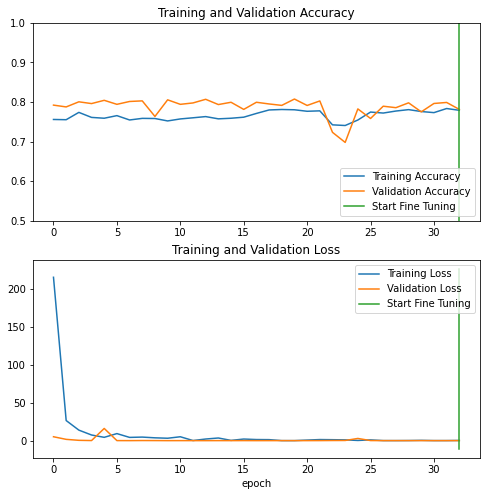

In [34]:


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [2]:
#%tensorboard --logdir /tmp/logs/fit
# Uncomment and run above line to see TensorBoard 

##### **Adding more epochs**

In [35]:
# What is happening here is that we are learning starting the model parameteres as it were at the end of the last training.
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x=X_train, 
                        y=y_train, 
                        validation_data=(X_test, y_test), 
                        callbacks=[tensorboard_callback, callback],
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1])


Epoch 33/43
2961/2961 [==============================] - 8s 3ms/step - loss: 0.7717 - accuracy: 0.7736 - val_loss: 0.7248 - val_accuracy: 0.7827
Epoch 34/43
2961/2961 [==============================] - 7s 3ms/step - loss: 0.7665 - accuracy: 0.7796 - val_loss: 0.7201 - val_accuracy: 0.7850
Epoch 35/43
2961/2961 [==============================] - 7s 2ms/step - loss: 0.7586 - accuracy: 0.7806 - val_loss: 0.6915 - val_accuracy: 0.7964
Epoch 36/43
2961/2961 [==============================] - 7s 2ms/step - loss: 0.9066 - accuracy: 0.7777 - val_loss: 0.7046 - val_accuracy: 0.7919
Epoch 37/43
2961/2961 [==============================] - 8s 3ms/step - loss: 0.7795 - accuracy: 0.7734 - val_loss: 0.7358 - val_accuracy: 0.7790
Epoch 38/43
2961/2961 [==============================] - 7s 2ms/step - loss: 0.9836 - accuracy: 0.7819 - val_loss: 0.7125 - val_accuracy: 0.7875
Epoch 39/43
2961/2961 [==============================] - 8s 3ms/step - loss: 0.7874 - accuracy: 0.7780 - val_loss: 0.6948 - val_ac

In [36]:
model.evaluate(X_test,y_test)

329/329 [==============================] - 0s 1ms/step - loss: 0.7162 - accuracy: 0.7864


[0.7162405848503113, 0.7863791584968567]

##### We see the accuracy has increased only a little, the correct way is to try to first have the accuracies converge in the first training and then we can expect to see a a significant increase in the second part of the training. For more information look at the following link: <br>
https://www.tensorflow.org/tutorials/images/transfer_learning

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


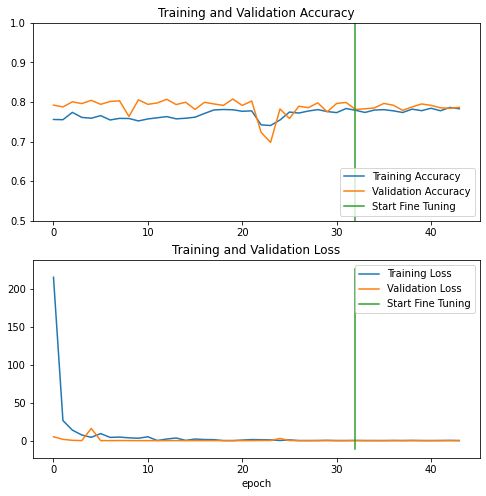

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#%tensorboard --logdir /tmp/logs/fit
# Uncomment and run above line to see TensorBoard 

##### **Plotting a confusion matrix of the predictions made by this network**

In [39]:
predictions = model.predict(X_test)
len(predictions)

10528

In [40]:
pred_classes = np.argmax(predictions, axis=-1)
pred_classes

array([6, 6, 3, ..., 6, 6, 6])

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

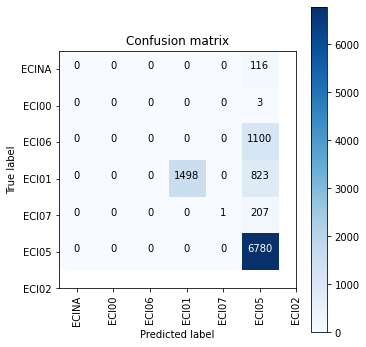

In [42]:
confusion_mtx = confusion_matrix(y_test, pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(set(data_dt['E_COM_INDICATOR']))) 
plt.show()

##### So we see that maximum accuracy is achieved on the class 'ECI01', 'ECI05' and correctly guessed one datapoint in 'ECI07'

In [49]:
import platform
print(platform.python_version())

3.6.9


### **ROUGH WORK**

In [ ]:
#https://www.tensorflow.org/tutorials/estimator/keras_model_to_estimator
